In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

,Station,PM 2.5
DATE_PST,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336


(228056, 2)


In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["MISSING"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

,Station,PM 2.5,MISSING
DATE_PST,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0


In [5]:
# Total missing values
master_df["MISSING"].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "MISSING"]]
    datasets[station].reset_index(inplace=True)

del master_df
datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
# Identifying isolated missing values and continuous missing values
# Auxiliar column to identify missing value interval lengths
for station in stations:
    # Initialize missing value sequency array and maximum sequence length
    nan_seq_length = np.zeros(len(datasets[station]))
    seq_max = 0
    for i in range(0, len(datasets[station])):
        seq = 0  # Sequence counter
        if not datasets[station].loc[i, "MISSING"]:
            breakpoint = (
                i - 1
            )  # Store previous id when entering a missing value sequence
        while datasets[station].loc[i, "MISSING"]:
            i += 1  # Add up to iterator while still missing
            seq += 1  # Add up to sequence length while still missing
        if seq:  # Check if in a missing sequence
            if seq_max < seq:  # If max sequence length < current sequence
                seq_max = seq  # Update maximum sequence length
        else:
            seq_max = 0  # If not in a missing sequence reset max sequence lenght
        # Update sequence length array with maximum sequence length
        nan_seq_length[(i - seq)] = seq_max
    datasets[station]["MISSING_SEQ"] = nan_seq_length.astype(int)

In [9]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["STATION"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "STATION", "PM 2.5", "MISSING", "MISSING_SEQ"]]
# master_df.drop("level_0", axis=1, inplace=True)

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ
DATE_PST,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0


### Thresholding missing sequence length
* Individual Missing Values (IMV)
* Continuous Missing Sample (CMS)

In [10]:
# Time threshold Tht
# MISSING_SEQ > Tht: Continuous missing samples (1)
# MISSING_SEQ <= Tht: Isolated missing value (0)
Tht = 6

master_df["MISSING_SAMPLE"] = np.where(master_df["MISSING_SEQ"] > Tht, 1, 0)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


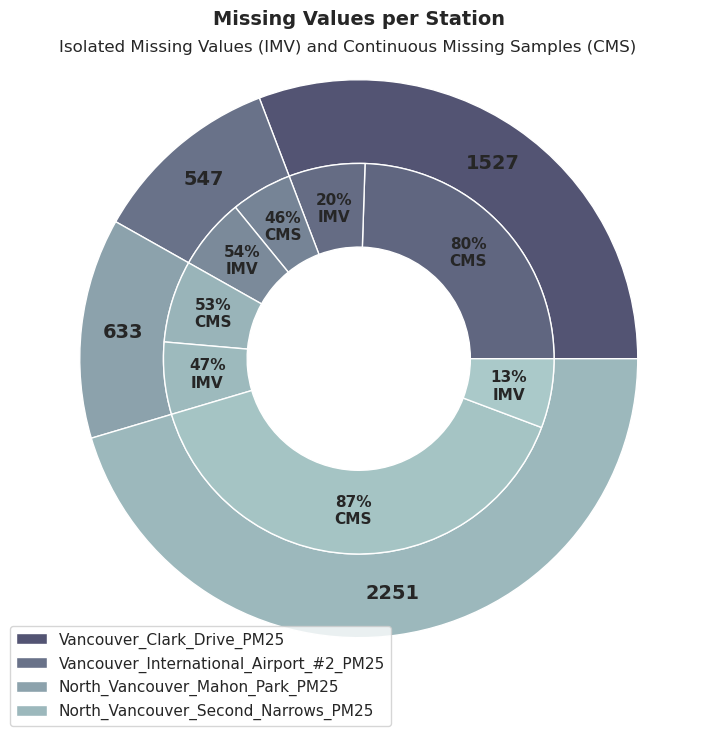

In [11]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cms_imv = []
stations_cms_imv_label = []

for station in pd.unique(master_df["STATION"]):
    stations.append(station)
    tot_missing_current = sum(master_df["MISSING"][master_df["STATION"] == station])
    tot_missing.append(tot_missing_current)
    tot_cms = sum(master_df["MISSING_SAMPLE"][master_df["STATION"] == station])
    stations_cms_imv.append(tot_cms)
    stations_cms_imv_label.append(f"{tot_cms/tot_missing_current * 100:.0f}%\nCMS")
    tot_imv = tot_missing_current - tot_cms
    stations_cms_imv.append(tot_imv)
    stations_cms_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

cm = plt.get_cmap("bone")
cout = cm([95, 120, 160, 178])
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.03))
plt.setp(pie, width=width, edgecolor="white")

cin = cm(np.array([110, 115, 135, 140, 175, 180, 188, 193]))
pie2, texts2 = ax.pie(
    stations_cms_imv,
    radius=1 - width,
    labels=stations_cms_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.97)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Samples (CMS)",
    fontsize=12,
    y=0.85,
)
plt.show()

## Imputation of Missing Values
* IMV imputation with cubic spline and linear interpolation
* CMS imputation with LSTM

### Auxiliar Functions to search and plot IMV and CMS

In [12]:
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


In [13]:
master_df["STATION"].unique()

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [14]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare
from tshelpers.metrics import rmse_score, mae_score

In [15]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="IMV", sequence_no=5)

179 IMV missing value sequences found with current arguments:
+-----+---------------------+---------------------+----------+
|     | Sequence Start      | Sequence End        | Length   |
|-----+---------------------+---------------------+----------|
|   0 | 2016-02-04 16:00:00 | 2016-02-04 17:00:00 | 1 h      |
|   1 | 2016-02-17 14:00:00 | 2016-02-17 15:00:00 | 1 h      |
|   2 | 2016-05-25 11:00:00 | 2016-05-25 13:00:00 | 2 h      |
|   3 | 2016-07-08 11:00:00 | 2016-07-08 12:00:00 | 1 h      |
|   4 | 2016-08-09 09:00:00 | 2016-08-09 13:00:00 | 4 h      |
|   5 | 2016-08-10 09:00:00 | 2016-08-10 14:00:00 | 5 h      |
|   6 | 2016-08-12 11:00:00 | 2016-08-12 14:00:00 | 3 h      |
|   7 | 2016-09-01 16:00:00 | 2016-09-01 18:00:00 | 2 h      |
|   8 | 2016-09-03 12:00:00 | 2016-09-03 14:00:00 | 2 h      |
|   9 | 2016-09-03 16:00:00 | 2016-09-03 17:00:00 | 1 h      |
|  10 | 2016-09-08 11:00:00 | 2016-09-08 13:00:00 | 2 h      |
|  11 | 2016-09-08 14:00:00 | 2016-09-08 15:00:00 | 1 h 

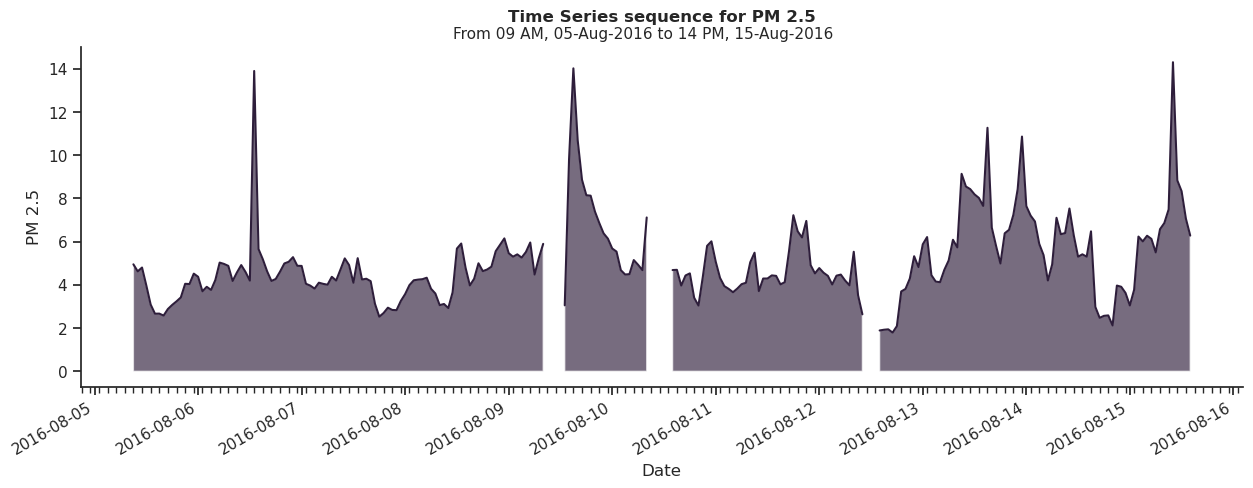

In [16]:
plot_sequence(data=station_subset, value="PM 2.5", start=interval[0], end=interval[1])

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods.

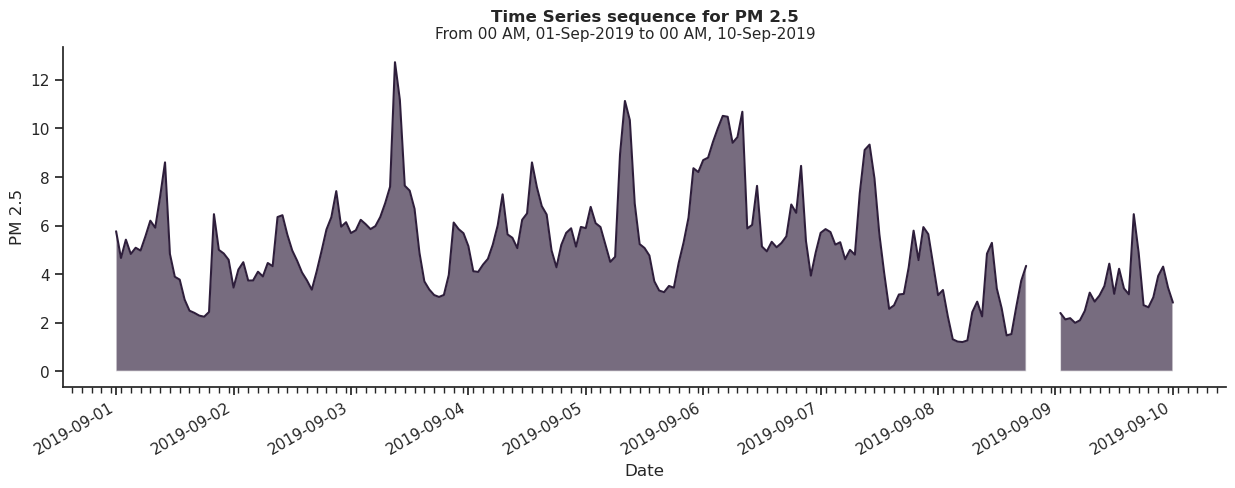

In [17]:
subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

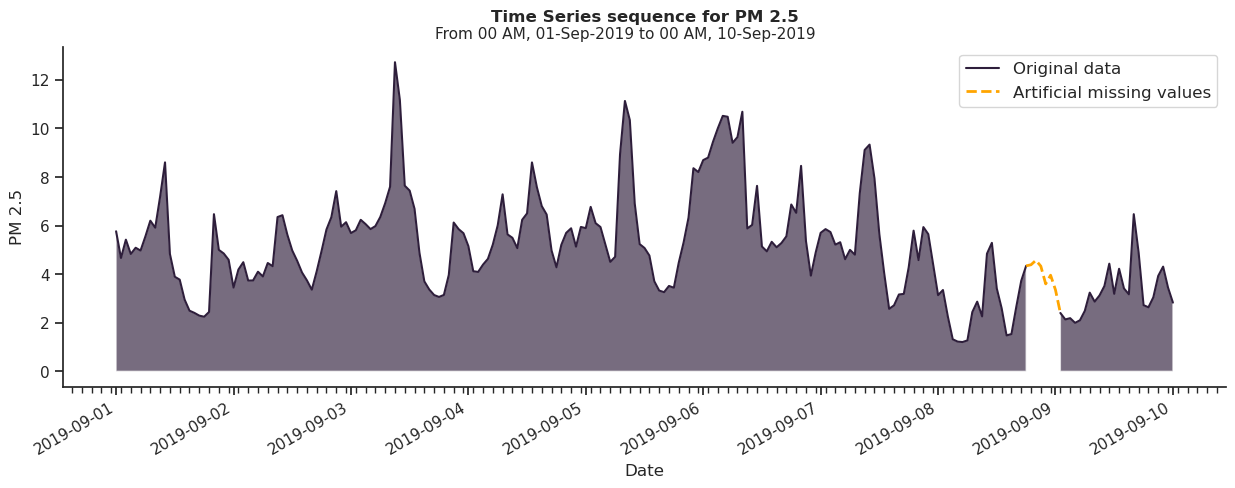

In [18]:
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
)

## Imputation of short sequences
* Short sequences are defined as the ones with two or less subsequent data points missing
* Testing between cubic spline and linear imputation

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods.

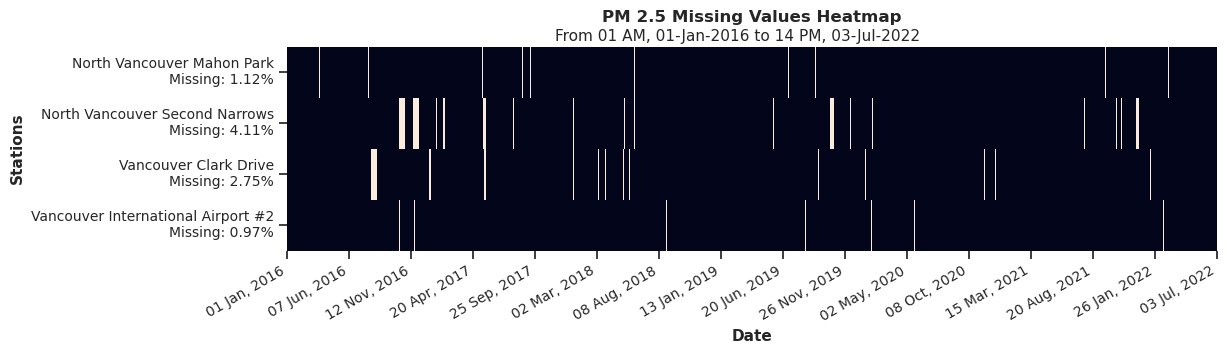

In [19]:
from tshelpers.plot import plot_missing
plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

In [20]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="CMS", sequence_no=0)

20 CMS missing value sequences found with current arguments:
+----+---------------------+---------------------+----------+
|    | Sequence Start      | Sequence End        | Length   |
|----+---------------------+---------------------+----------|
|  0 | 2016-03-23 11:00:00 | 2016-03-24 01:00:00 | 14 h     |
|  1 | 2016-07-26 11:00:00 | 2016-07-27 00:00:00 | 13 h     |
|  2 | 2016-08-17 11:00:00 | 2016-08-18 14:00:00 | 27 h     |
|  3 | 2017-05-12 05:00:00 | 2017-05-14 19:00:00 | 62 h     |
|  4 | 2017-05-17 13:00:00 | 2017-05-18 12:00:00 | 23 h     |
|  5 | 2017-07-07 19:00:00 | 2017-07-08 10:00:00 | 15 h     |
|  6 | 2017-09-13 14:00:00 | 2017-09-13 21:00:00 | 7 h      |
|  7 | 2018-06-23 04:00:00 | 2018-06-23 13:00:00 | 9 h      |
|  8 | 2018-11-04 15:00:00 | 2018-11-05 03:00:00 | 12 h     |
|  9 | 2019-03-10 07:00:00 | 2019-03-10 15:00:00 | 8 h      |
| 10 | 2019-05-27 14:00:00 | 2019-05-28 05:00:00 | 15 h     |
| 11 | 2019-07-03 08:00:00 | 2019-07-05 00:00:00 | 40 h     |
| 12 | 20

In [21]:
# Looking for months without missing values
for station in stations:
    station_subset = master_df[master_df["STATION"] == station]
    print(f"Complete months in station {station}:")
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                print(f"{month}-{year}")

Complete months in station Vancouver_Clark_Drive_PM25:
4-2016
10-2016
2-2019
Complete months in station Vancouver_International_Airport_#2_PM25:
4-2016
7-2016
4-2019
Complete months in station North_Vancouver_Mahon_Park_PM25:
1-2016
4-2016
6-2016
6-2017
2-2018
Complete months in station North_Vancouver_Second_Narrows_PM25:
2-2016
6-2016
7-2016
3-2017
4-2017
9-2017
2-2019
4-2019
6-2019


### Experimentation subsets
* Vancouver Clark Drive
    * 4-2016
    * 2-2019
* Vancouver International Airport:
    * 4-2016
    * 4-2019
* North Vancouver Mahon Park:
    * 6-2016
    * 6-2017
* North Vancouver Second Narrows:
    * 2-2016
    * 6-2016
    * 4-2017
    * 9-2017
    * 4-2019
    * 6-2019

In [22]:
# Experimental subsets
exp_subsets = {
    "Vancouver_Clark_Drive_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "2-2019": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2019, 2, 1):datetime(2019, 3, 1)],
    },
    "Vancouver_International_Airport_#2_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "4-2019": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
    },
    "North_Vancouver_Mahon_Park_PM25": {
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "6-2017": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2017, 6, 1):datetime(2017, 7, 1)],
    },
    "North_Vancouver_Second_Narrows_PM25": {
        "2-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 2, 1):datetime(2016, 3, 1)],
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "4-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 4, 1):datetime(2017, 5, 1)],
        "9-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 9, 1):datetime(2017, 10, 1)],
        "4-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
        "6-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 6, 1):datetime(2019, 7, 1)],
    }
}

### Experimentation method
Backwards missing value generation.

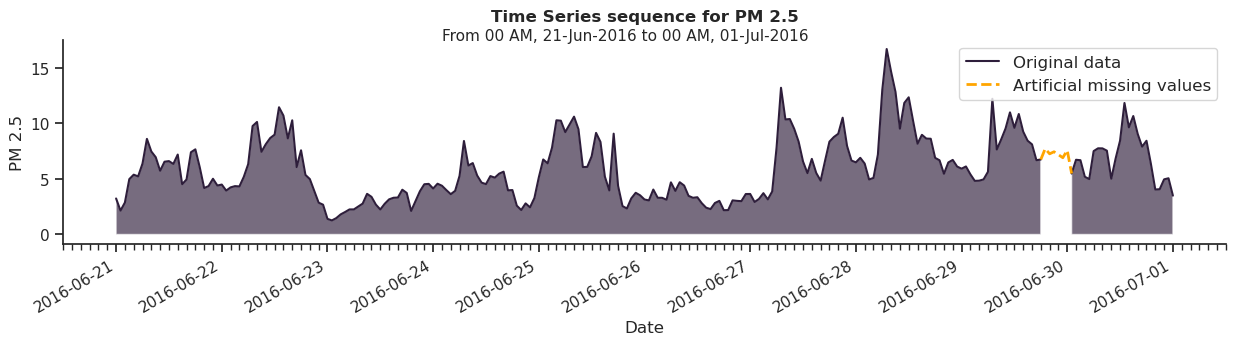

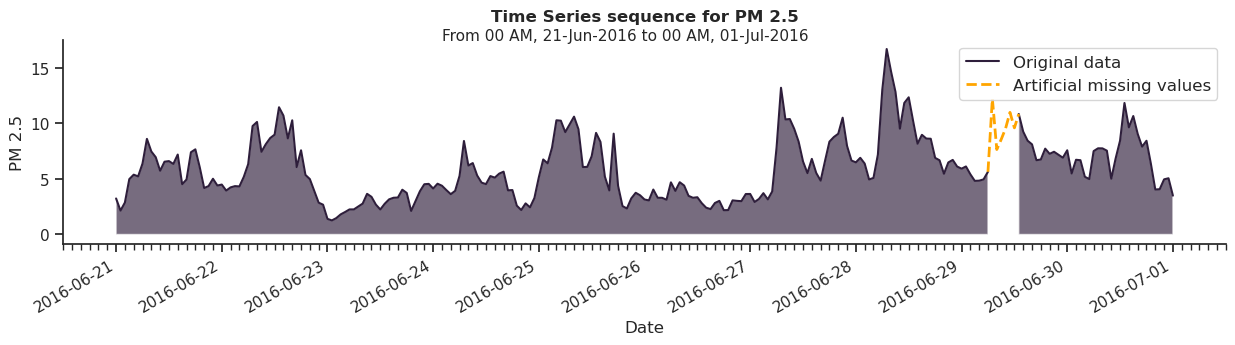

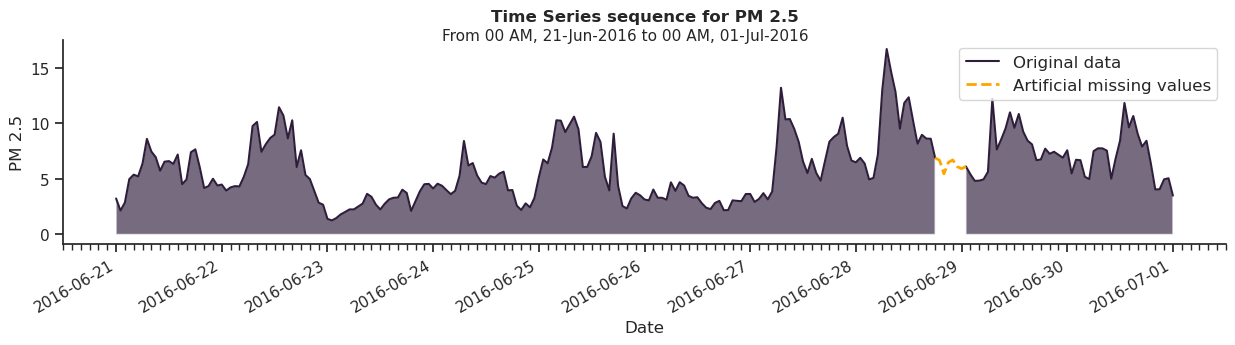

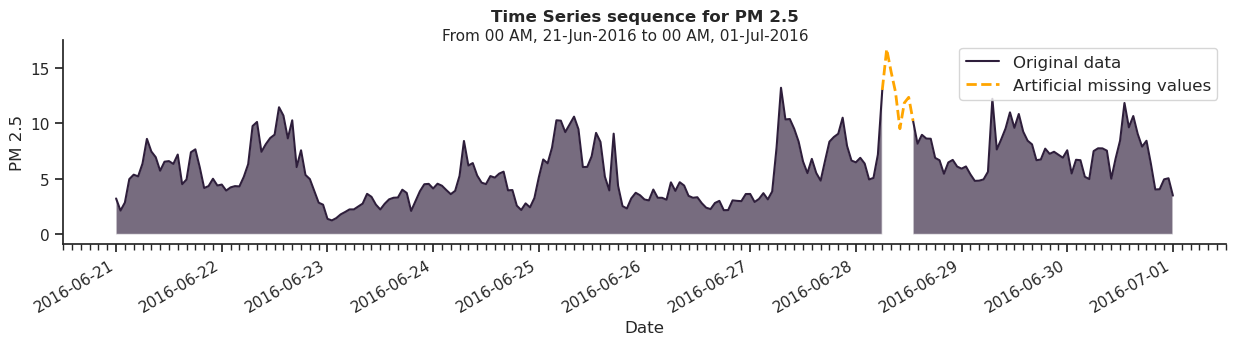

In [23]:
# Implementation example iterating through different paddings:
paddings = [24, 36, 48, 60]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

Imputation example with linear interpolation.

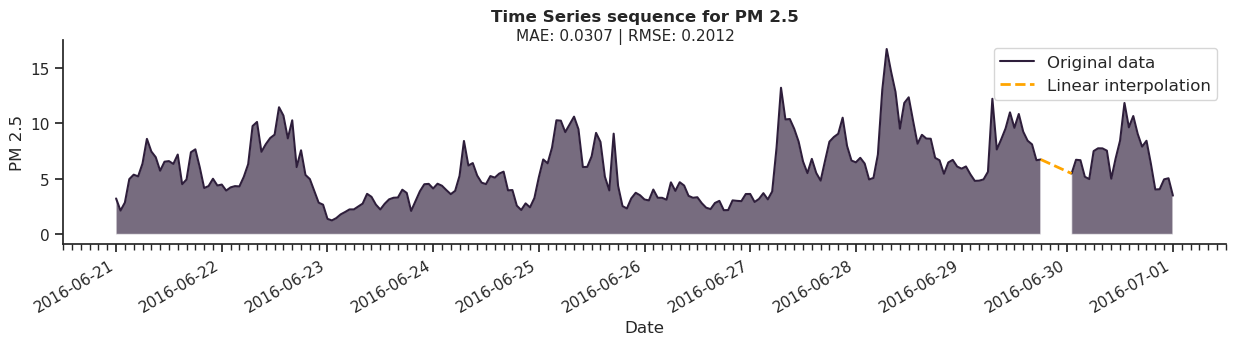

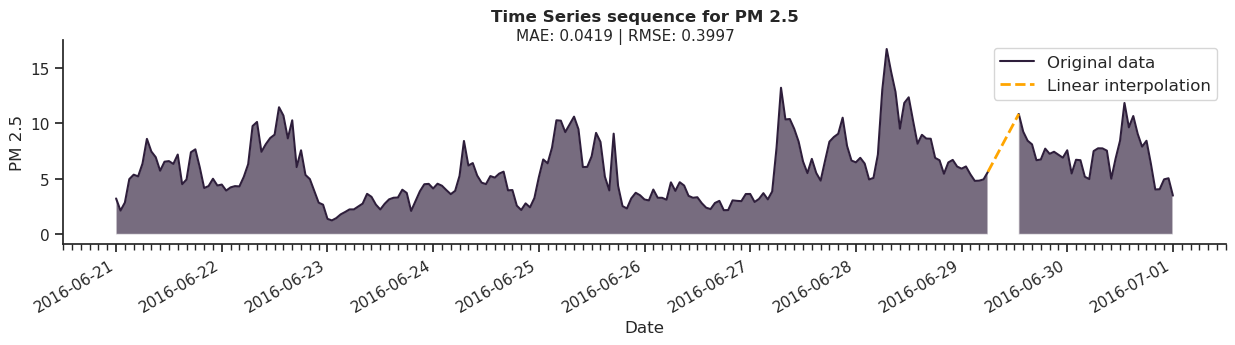

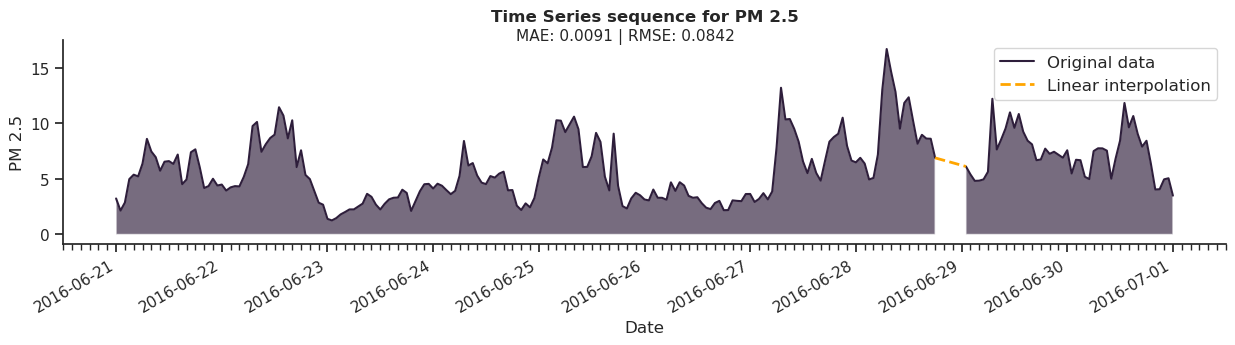

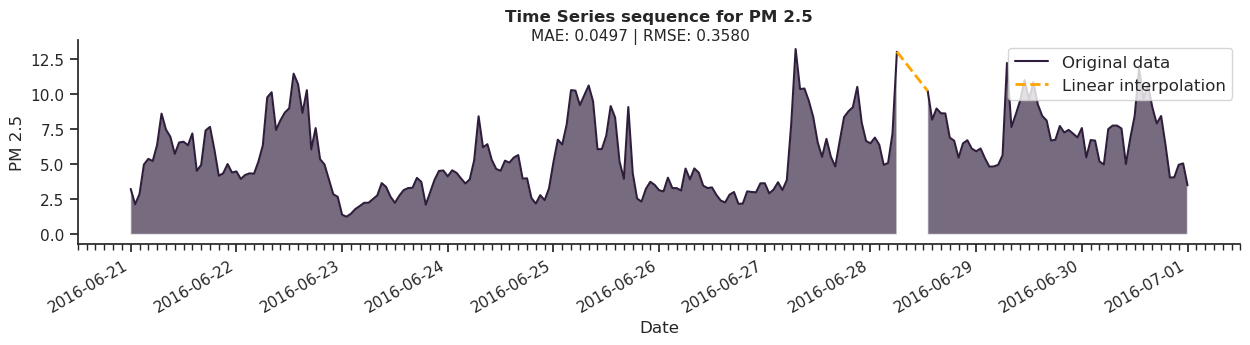

In [27]:
# Implementation example with linear interpolation:
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_linear = subset.copy()
    subset_linear["PM 2.5"] = (
        subset_missing["PM 2.5"].interpolate(method="linear").tolist()
    )
    
    plot_compare(
        subset_linear,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Linear interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

Imputation example with cubic spline.

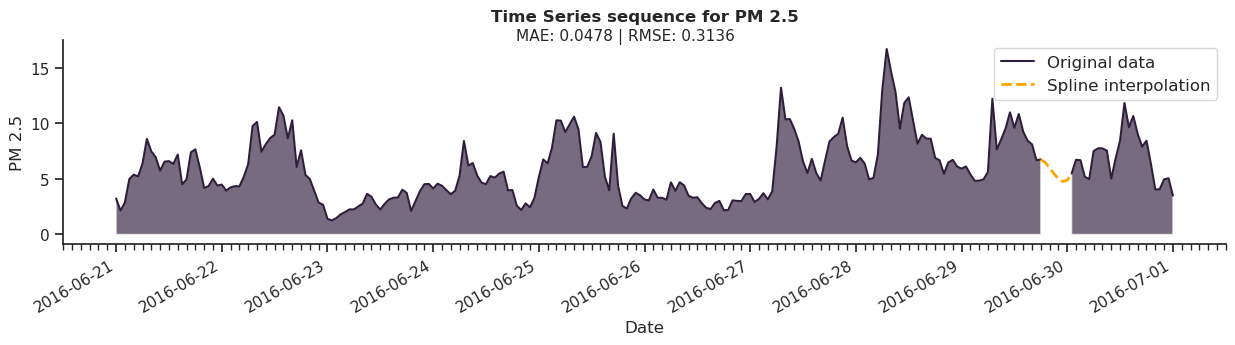

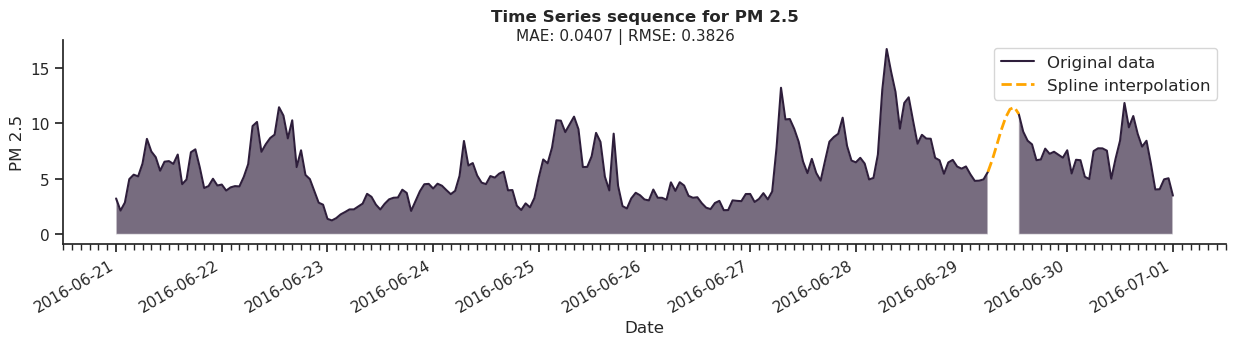

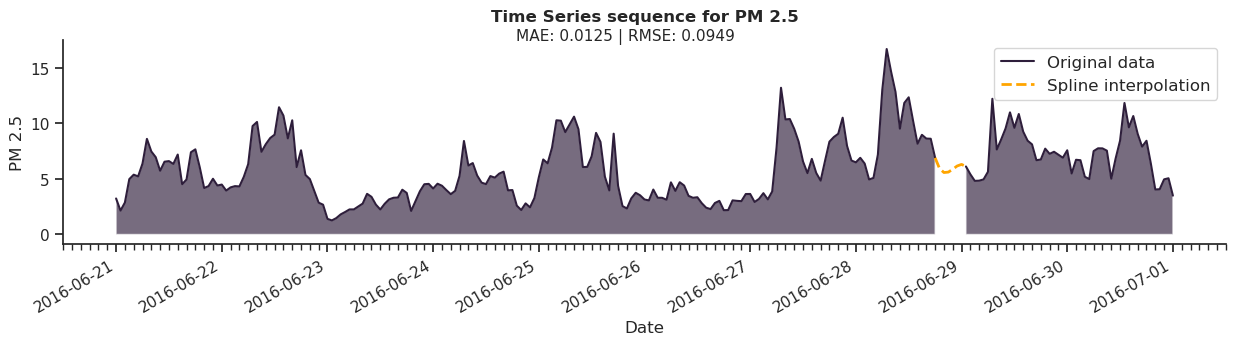

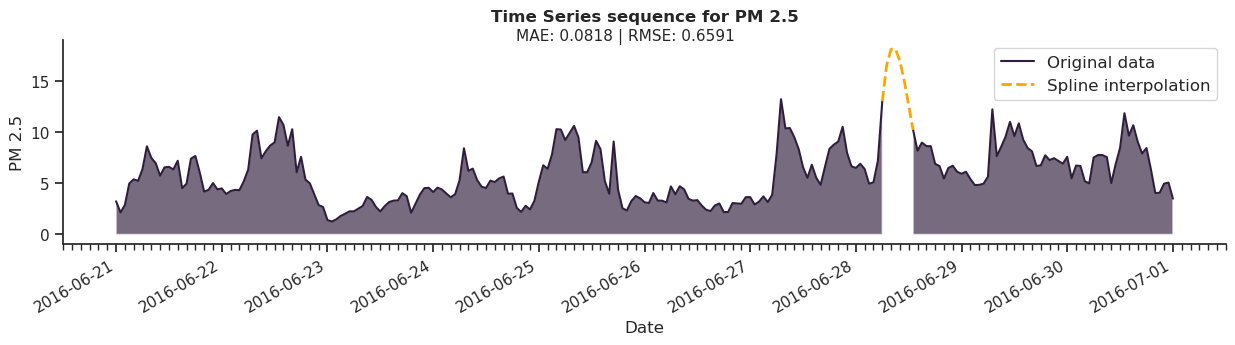

In [28]:
# Implementation example with spline interpolation:
pd.options.mode.chained_assignment = None
from scipy import interpolate

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978. pp 40-50_

### Linear and Cubic Spline imputation of Short Sequences
* Iteration through missing lengths ∈ (1h, 2h)
* For each subset, generate missing lengths on every hour, from right to left
* Measure Root-Mean-Square Error (RMSE) and Mean-Absolute Error (MAE) against original data

In [31]:
%%time
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

# Artificial missing values function parameters
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
for station in (pbar := tqdm(exp_subsets)):
    pbar.set_description(f"Processing station {station}")
    for station_subset in exp_subsets[station]:
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic"] = []
        imputation_results[imputation_step]["RMSE_Linear"] = []
        imputation_results[imputation_step]["MAE_Cubic"] = []
        imputation_results[imputation_step]["MAE_Linear"] = []
        imputation_results[imputation_step]["Missing_Length"] = []        
        # Generating backwards missing intervals
        paddings = [i for i in range(2, len(exp_subsets[station][station_subset]))]
        for padding in paddings:
            # Creating missing interval with length = 1 and length = 2
            for length in [1, 2]:
                subset, subset_missing = create_missing(
                    **create_missing_args,
                    data=exp_subsets[station][station_subset],
                    padding=padding,
                    missing_length=length
                )
                ### Cubic spline
                subset_spline = subset.copy()
                missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

                # Indexing boundary values at t-2, t-1, t+1, and t+2
                boundary_idx = []
                for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                    if idx not in missing_idx:
                        boundary_idx.append(idx)
                boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

                # Fitting cubic spline
                cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
                imputed = interpolate.splev(missing_idx, cubic_spline)
                subset_spline["PM 2.5"][missing_idx] = imputed

                # Evaluating cubic spline
                rmse_cubic = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
                mae_cubic = mae_score(subset, subset_spline, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Cubic"].append(rmse_cubic)
                imputation_results[imputation_step]["MAE_Cubic"].append(mae_cubic)

                ### Linear interpolation
                subset_linear = subset.copy()
                subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

                # Evaluating linear interpolation
                rmse_linear = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
                mae_linear = mae_score(subset, subset_linear, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Linear"].append(rmse_linear)
                imputation_results[imputation_step]["MAE_Linear"].append(mae_linear)
                imputation_results[imputation_step]["Missing_Length"].append(length)

Processing station North_Vancouver_Second_Narrows_PM25: 100%|██████████| 4/4 [01:27<00:00, 21.87s/it]    

CPU times: user 1min 27s, sys: 16.9 ms, total: 1min 27s
Wall time: 1min 27s


In [32]:
# Concatenating master dataframe
subsets = []
for subset in imputation_results.keys():
    subsets.append(pd.DataFrame(imputation_results[subset]))

metrics_df = pd.concat(subsets).reset_index(drop=True)
metrics_df.round(6).head()

,RMSE_Cubic,RMSE_Linear,MAE_Cubic,MAE_Linear,Missing_Length
0,0.033493,0.024058,0.001247,0.000896,1
1,0.050441,0.051899,0.001883,0.002001,2
2,0.050351,0.050928,0.001875,0.001897,1
3,0.059907,0.051147,0.002644,0.001921,2
4,0.026684,0.025138,0.000994,0.000936,1


### RMSE and MAE results

In [33]:
metrics_df.groupby("Missing_Length").describe(percentiles=[]).T.round(5)

Missing_Length              1           2
RMSE_Cubic  count  8556.00000  8556.00000
            mean      0.03426     0.06690
            std       0.05219     0.08590
            min       0.00001     0.00024
            50%       0.01770     0.03985
            max       0.80107     1.29857
RMSE_Linear count  8556.00000  8556.00000
            mean      0.03296     0.06172
            std       0.05039     0.07897
            min       0.00000     0.00000
            50%       0.01714     0.03716
            max       0.78733     1.38782
MAE_Cubic   count  8556.00000  8556.00000
            mean      0.00128     0.00326
            std       0.00196     0.00423
            min       0.00000     0.00001
            50%       0.00066     0.00191
            max       0.03088     0.06828
MAE_Linear  count  8556.00000  8556.00000
            mean      0.00123     0.00299
            std       0.00189     0.00385
            min       0.00000     0.00000
            50%       0.00064     0.00180
            max       0.03002     0.07297

In [34]:
# Melting dataframes for boxplot visualizations
RMSE_melt_df = pd.melt(metrics_df[["RMSE_Cubic", "RMSE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="RMSE")

MAE_melt_df = pd.melt(metrics_df[["MAE_Cubic", "MAE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="MAE")

display(RMSE_melt_df.head())
display(MAE_melt_df.head())

,Length,Method,RMSE
0,1,Cubic,0.033493
1,2,Cubic,0.050441
2,1,Cubic,0.050351
3,2,Cubic,0.059907
4,1,Cubic,0.026684


,Length,Method,MAE
0,1,Cubic,0.001247
1,2,Cubic,0.001883
2,1,Cubic,0.001875
3,2,Cubic,0.002644
4,1,Cubic,0.000994


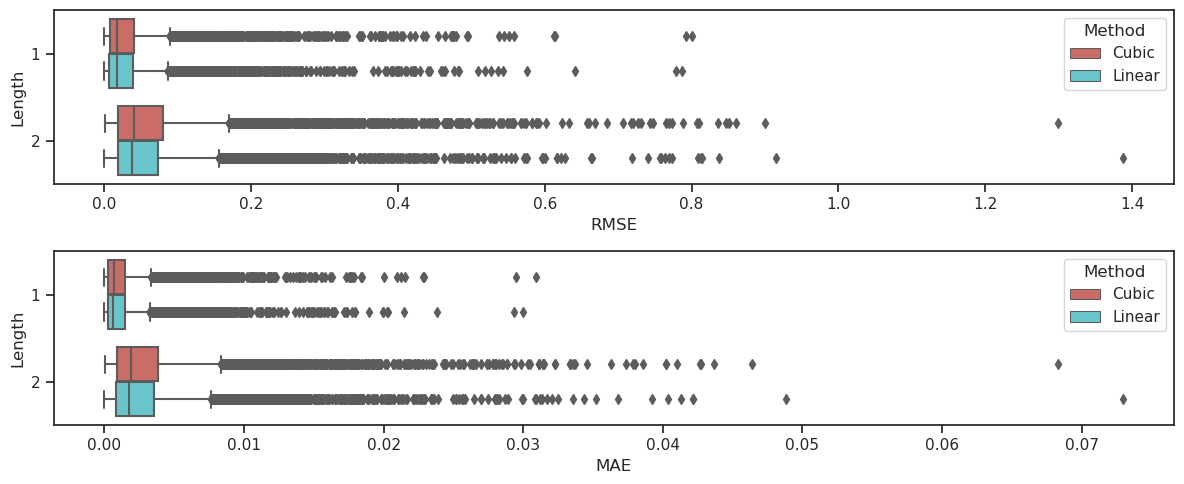

In [35]:
# Boxplot of metrics results
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
box_plot_args = {
    "y": "Length",
    "hue": "Method",
    "palette": "hls",
    "orient": "h"
}
sns.boxplot(RMSE_melt_df,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

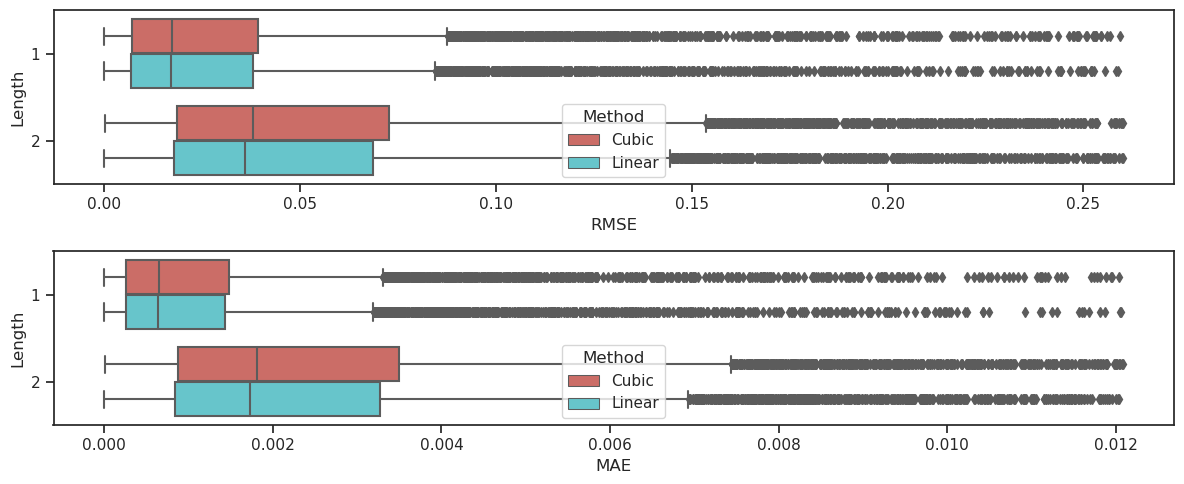

In [36]:
# Metrics without outliers
RMSE_melt_df_noout = RMSE_melt_df[(np.abs(stats.zscore(RMSE_melt_df["RMSE"])) < 3)]
MAE_melt_df_noout = MAE_melt_df[(np.abs(stats.zscore(MAE_melt_df["MAE"])) < 3)]

# Boxplot of metrics results without outliers
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sns.boxplot(RMSE_melt_df_noout,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df_noout,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

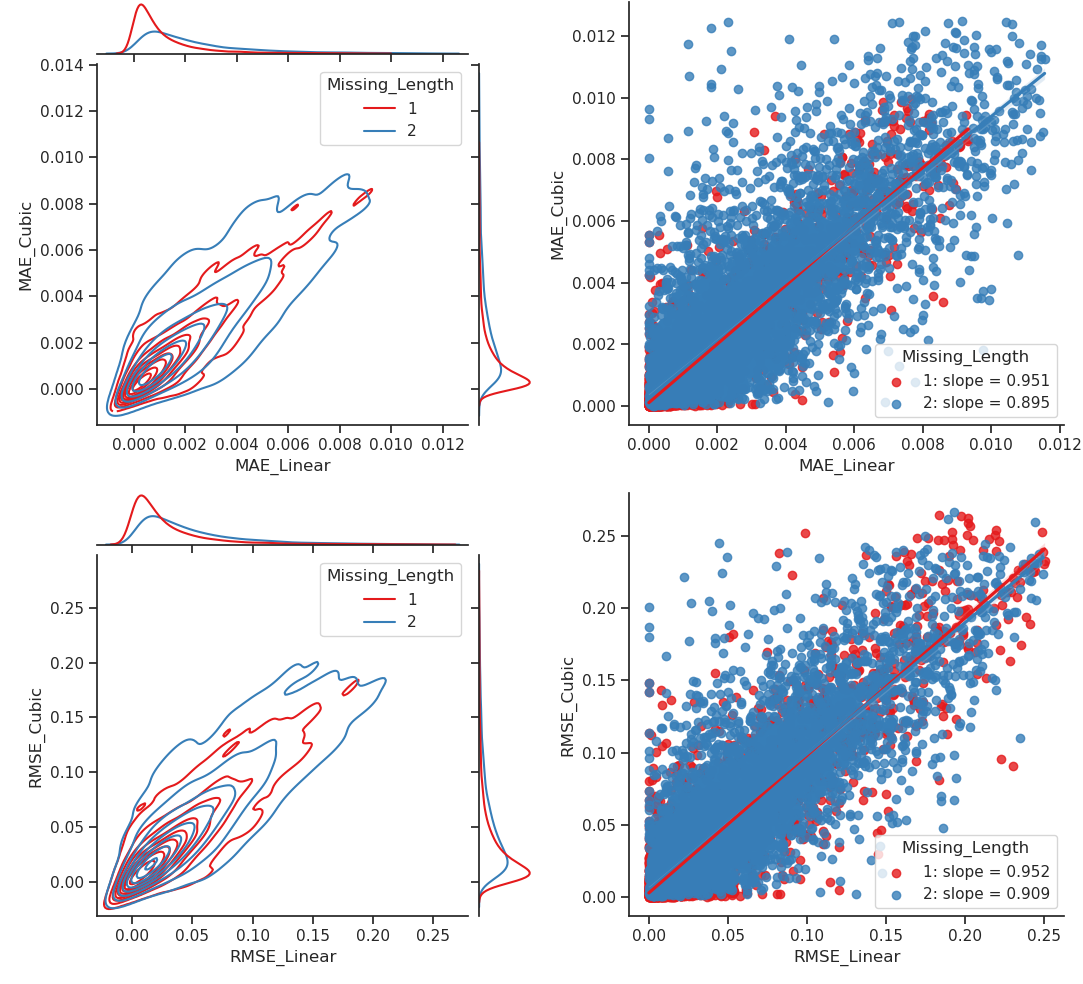

In [37]:
# Plotting pair and regression plots for 1h and 2h missing lengths
from tshelpers.plot import SeabornFig2Grid
from matplotlib import gridspec

# Metrics without outliers
metrics_df_noout = metrics_df[(np.abs(stats.zscore(metrics_df)) < 3).all(axis=1)]

# Regression slopes MAE
lr_mae_1 = stats.linregress(metrics_df_noout['MAE_Linear'][metrics_df_noout["Missing_Length"] == 1],
                      metrics_df_noout['MAE_Cubic'][metrics_df_noout["Missing_Length"] == 1])
lr_mae_2 = stats.linregress(metrics_df_noout['MAE_Linear'][metrics_df_noout["Missing_Length"] == 2],
                      metrics_df_noout['MAE_Cubic'][metrics_df_noout["Missing_Length"] == 2])
# Regression slopes RMSE
lr_rmse_1 = stats.linregress(metrics_df_noout['RMSE_Linear'][metrics_df_noout["Missing_Length"] == 1],
                      metrics_df_noout['RMSE_Cubic'][metrics_df_noout["Missing_Length"] == 1])
lr_rmse_2 = stats.linregress(metrics_df_noout['RMSE_Linear'][metrics_df_noout["Missing_Length"] == 2],
                      metrics_df_noout['RMSE_Cubic'][metrics_df_noout["Missing_Length"] == 2])

plot_args_mae = {
    "data": metrics_df_noout,
    "x": "MAE_Linear",
    "y": "MAE_Cubic",
    "hue": "Missing_Length",
    "palette": "Set1"
}
plot_args_rmse = {
    "data": metrics_df_noout,
    "x": "RMSE_Linear",
    "y": "RMSE_Cubic",
    "hue": "Missing_Length",
    "palette": "Set1"
}

# Joint and Regression plots
joint1 = sns.jointplot(**plot_args_mae,
              kind="kde")
lm1 = sns.lmplot(**plot_args_mae,
              legend_out=False)
ax = lm1.axes[0, 0]
leg1 = ax.get_legend()
L_labels1 = leg1.get_texts()
L_labels1[0].set_text(f"1: slope = {lr_mae_1.slope:.3f}")
L_labels1[1].set_text(f"2: slope = {lr_mae_2.slope:.3f}")

joint2 = sns.jointplot(**plot_args_rmse,
              kind="kde")
lm2 = sns.lmplot(**plot_args_rmse,
              legend_out=False)            
ax = lm2.axes[0, 0]
leg2 = ax.get_legend()
L_labels2 = leg2.get_texts()
L_labels2[0].set_text(f"1: slope = {lr_rmse_1.slope:.3f}")
L_labels2[1].set_text(f"2: slope = {lr_rmse_2.slope:.3f}")

# Figure plot grid
fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(2, 2)

# Mapping subfigures to figure grid with SeabornFig2Grid
mg0 = SeabornFig2Grid(joint1, fig, gs[0])
mg1 = SeabornFig2Grid(lm1, fig, gs[1])
mg2 = SeabornFig2Grid(joint2, fig, gs[2])
mg3 = SeabornFig2Grid(lm2, fig, gs[3])
gs.tight_layout(fig)
plt.show()

### Test of statistical significance

In [39]:
# Shapiro-Wilk Test of normality
'''
H0: The sample is drawn from a normal distribution.
Ha: The sample is not drawn from a normal distribution.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
'''
for length in [1, 2]:
    for method in metrics_df.columns[:-1]:
        shap = stats.shapiro(metrics_df[method][metrics_df["Missing_Length"] == length])
        shap_p = shap.pvalue
        if shap_p > 0.05:
            print(f"Method {method} is normally distributed with p-value {shap_p}")
        else:
            print(f"Method {method} is not normally distributed with p-value {shap_p}")

Method RMSE_Cubic is not normally distributed with p-value 0.0
Method RMSE_Linear is not normally distributed with p-value 0.0
Method MAE_Cubic is not normally distributed with p-value 0.0
Method MAE_Linear is not normally distributed with p-value 0.0
Method RMSE_Cubic is not normally distributed with p-value 0.0
Method RMSE_Linear is not normally distributed with p-value 0.0
Method MAE_Cubic is not normally distributed with p-value 0.0
Method MAE_Linear is not normally distributed with p-value 0.0


In [40]:
# Wilcoxon signed-rank test for paired samples
'''
H0: Distribution of the differences between samples is symmetric about zero (Sample distributions are equal).
Ha: Distribution of the differences between samples is not symmetric about zero (Sample distributions are not equal).
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
'''
for length in [1, 2]:
    subset = metrics_df[metrics_df["Missing_Length"] == length]
    for metric in ["RMSE", "MAE"]:
        wilc = stats.wilcoxon(subset[f"{metric}_Cubic"], subset[f"{metric}_Linear"])
        wilc_p = wilc.pvalue
        if wilc_p > 0.05:
            print(f"{metric} metric is statistically equal between Cubic and Linear short sequence imputation for {length}h length with p-value {wilc_p:.9f}")
        else:
            print(f"{metric} metric is statistically different between Cubic and Linear short sequence imputation for {length}h length with p-value {wilc_p:.9f}")

RMSE metric is statistically different between Cubic and Linear short sequence imputation for 1h length with p-value 0.000000850
MAE metric is statistically different between Cubic and Linear short sequence imputation for 1h length with p-value 0.000000892
RMSE metric is statistically different between Cubic and Linear short sequence imputation for 2h length with p-value 0.000000000
MAE metric is statistically different between Cubic and Linear short sequence imputation for 2h length with p-value 0.000000000
